In [2]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split

In [146]:
def ou_accuracy(actu,pred):
    with open('data/df_2000_2019.pkl','rb') as f:
        dfall = pickle.load(f)
    ou = dfall.loc[actu.index,'Over_Under']
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
        tot = (actu<ou).sum() + (actu>ou).sum()
        return corr/tot

In [4]:
def regress(reg,Xtrain,Xtest,ytrain,ytest,cv=5,print_metrics=True,print_coef=True,return_metrics=False):
    robust = RobustScaler()
    sca_train = robust.fit_transform(Xtrain)
    sca_test = robust.transform(Xtest)
    val = cross_validate(reg, sca_train, ytrain, cv=cv, return_estimator=True,
                                scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
                                        'acc':make_scorer(ou_accuracy,greater_is_better=True)})
    acc = (np.mean(val['test_acc']),np.std(val['test_acc']))
    mae = (np.mean(-val['test_mae']),np.std(-val['test_mae']))
    best_estimator = val['estimator'][val['test_mae'].argmax()]

    ypred=best_estimator.predict(sca_test)
    mae_test=mean_absolute_error(ytest,ypred)
    acc_test = ou_accuracy(ytest,ypred)
    sorted_coef = get_coef(best_estimator.coef_,Xtrain.columns)
    if print_metrics:
        print(f'MAE_train = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
        print(-val['test_mae'])
#        print(f'MAE_test = {mae_test:.3f}, Accuracy_test = {acc_test:.3f}')
    if print_coef:
        print(sorted_coef)
    if return_metrics:
        return mae_test,acc_test
    else:
        return

In [5]:
def get_coef(coef_,cols):
    coef = pd.DataFrame(coef_, cols, columns=['LR Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

In [6]:
path = 'data/df_complete.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']
LR = linear_model.LinearRegression()
robust = RobustScaler()

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Use training ratio of 70% for VIF analysis
train_ratio = 0.70

path = 'data/df_working5.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

In [367]:
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts'
        ,'H_Pts_Opp','V_Pts_Opp']
#vifdrop=['H_TD','V_TD','Year','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric',
#         'H_Pts','V_Pts','H_Pts_Opp','V_Pts_Opp']
X = X.drop(vifdrop,axis=1)
# W/out Pass/Rush Metrics, Scores, Possession, Plays, dome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
vif.round(2).sort_values(by='VIF Factor',ascending=False)

,Features,VIF Factor
16,H_Poss,2.96
17,V_Poss,2.74
18,H_Plays,2.52
0,H_Off_Pass,2.43
19,V_Plays,2.43
1,V_Off_Pass,2.41
37,dome,2.38
2,H_Off_Rush,1.83
3,V_Off_Rush,1.70
35,Wind,1.70


In [375]:
X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','H_Def_Pass','V_Def_Pass','H_Def_Rush',
            'V_Def_Rush','V_RZ_Def_Pct','V_Sacks_Def','V_Puntret','Wind','grass','dome','Year']]
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
vif.round(2).sort_values(by='VIF Factor',ascending=False)

,Features,VIF Factor
0,H_Pts,2.16
1,H_Off_Pass,1.95
14,dome,1.90
3,H_Off_Rush,1.73
12,Wind,1.61
13,grass,1.31
2,V_Off_Pass,1.27
4,V_Off_Rush,1.25
8,V_Def_Rush,1.21
9,V_RZ_Def_Pct,1.19


In [26]:
vifdrop=['H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric',
         'H_Pts','V_Pts','H_Pts_Opp','V_Pts_Opp','H_Poss','V_Poss','dome','H_Plays','V_Plays']

from statsmodels.stats.outliers_influence import variance_inflation_factor
# Use training ratio of 70% for VIF analysis
train_ratio = 0.70

path = 'data/df_working5.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(turf,axis=1)
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']

In [373]:
# Not scaled, no turf
import statsmodels.api as sm
train_ratio = 0.7
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp']
X = X.drop(vifdrop,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_train = sm.add_constant(X_train)
OLS = sm.OLS(y_train, X_train).fit()
ypred=OLS.predict(X_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
#get_coef(LR.coef_,X_train.columns)
OLS.summary()

MAE = 10.446591582499787
Training Accuracy = 0.5525876460767947


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.252
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           9.89e-11
Time:                        06:39:09   Log-Likelihood:                -4851.7
No. Observations:                1214   AIC:                             9785.
Df Residuals:                    1173   BIC:                             9995.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            467.8608    349.390      1.339      0.181    -217.639    1153.360
H_Off_Pass         0.0303      0.014      2.203      0.028       0.003       0.057
V_Off_Pass         0.0511      0.013      3.825      0.000       0.025       0.077
H_Off_Rush         0.0349      0.019      1.855      0.064      -0.002       0.072
V_Off_Rush         0.0446      0.019      2.330      0.020       0.007       0.082
H_Def_Pass         0.0200      0.013      1.509      0.132      -0.006       0.046
V_Def_Pass         0.0107      0.013      0.827      0.409      -0.015       0.036
H_Def_Rush         0.0374      0.019      1.946      0.052      -0.000       0.075
V_Def_Rush         0.0351      0.019      1.840      0.066      -0.002       0.073
H_TD_on_Def       -2.5650      2.344     -1.094      0.274      -7.164       2.034
V_TD_on_Def       -2.0473      2.402     -0.852      0.394      -6.760       2.665
H_FG_Pct          -0.5019      3.154     -0.159      0.874      -6.691       5.687
V_FG_Pct           4.5016      3.012      1.495      0.135      -1.408      10.411
H_RZ_Pct           1.3464      3.646      0.369      0.712      -5.808       8.501
V_RZ_Pct           2.1359      3.684      0.580      0.562      -5.092       9.364
H_RZ_Def_Pct      -3.0566      3.474     -0.880      0.379      -9.873       3.760
V_RZ_Def_Pct       7.4161      3.627      2.045      0.041       0.301      14.531
H_Poss            -0.0652      0.293     -0.223      0.824      -0.640       0.510
V_Poss            -0.2939      0.288     -1.019      0.308      -0.860       0.272
H_Plays            0.1018      0.132      0.772      0.440      -0.157       0.360
V_Plays            0.0863      0.132      0.655      0.512      -0.172       0.345
H_TO_Gain          0.9165      0.750      1.221      0.222      -0.556       2.389
V_TO_Gain          0.8748      0.732      1.195      0.233      -0.562       2.312
H_TO_Lost         -0.9708      0.716     -1.356      0.175      -2.375       0.434
V_TO_Lost         -0.1081      0.688     -0.157      0.875      -1.457       1.241
H_Yds_Pen          0.0134      0.032      0.418      0.676      -0.049       0.076
V_Yds_Pen         -0.0089      0.031     -0.290      0.772      -0.069       0.051
H_Sacks_Def        0.5040      0.611      0.825      0.410      -0.695       1.703
V_Sacks_Def        0.8705      0.613      1.419      0.156      -0.333       2.074
H_Tackles_Loss     0.0554      0.450      0.123      0.902      -0.827       0.938
V_Tackles_Loss     0.2658      0.433      0.614      0.539      -0.584       1.115
H_Kickret         -0.0469      0.075     -0.622      0.534      -0.195       0.101
V_Kickret          0.0738      0.072      1.030      0.303      -0.067       0.214
H_Puntret         -0.0473      0.103     -0.461      0.645      -0.249       0.154
V_Puntret   

In [ ]:
# 
import statsmodels.api as sm
train_ratio = 0.7
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp']
X = X.drop(vifdrop,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_train = sm.add_constant(X_train)
OLS = sm.OLS(y_train, X_train).fit()
ypred=OLS.predict(X_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
#get_coef(LR.coef_,X_train.columns)
OLS.summary()

In [425]:
import statsmodels.api as sm
train_ratio = 0.7
# X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','H_Def_Pass','V_Def_Pass','H_Def_Rush',
#             'V_Def_Rush','V_RZ_Def_Pct','V_Sacks_Def','V_Puntret','Wind','grass','dome','Year']]
X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','V_Off_Rush','H_Def_Pass','V_Def_Pass','H_Def_Rush',
            'V_Def_Rush','V_RZ_Def_Pct','V_Sacks_Def','V_Puntret','Wind','dome','Year'
           ,'a_turf','matrixturf','sportturf']]
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
sca_train = pd.DataFrame(robust.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
sca_train = sm.add_constant(sca_train)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
OLS.summary()

MAE = 10.435345076936729
Training Accuracy = 0.5575959933222037


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     7.152
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           7.12e-17
Time:                        12:22:50   Log-Likelihood:                -4856.8
No. Observations:                1214   AIC:                             9750.
Df Residuals:                    1196   BIC:                             9841.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           45.2526      0.541     83.671      0.000      44.191      46.314
H_Pts            1.8893      0.612      3.085      0.002       0.688       3.091
H_Off_Pass       0.9627      0.629      1.530      0.126      -0.272       2.197
V_Off_Pass       3.2192      0.611      5.267      0.000       2.020       4.418
V_Off_Rush       1.2960      0.565      2.295      0.022       0.188       2.404
H_Def_Pass       0.8659      0.565      1.533      0.125      -0.242       1.974
V_Def_Pass       1.0044      0.559      1.797      0.073      -0.092       2.101
H_Def_Rush       0.7462      0.522      1.429      0.153      -0.278       1.770
V_Def_Rush       1.3333      0.569      2.344      0.019       0.217       2.449
V_RZ_Def_Pct     1.0555      0.554      1.906      0.057      -0.031       2.142
V_Sacks_Def      1.1815      0.514      2.300      0.022       0.174       2.189
V_Puntret       -1.0641      0.456     -2.332      0.020      -1.959      -0.169
Wind            -2.5890      0.780     -3.321      0.001      -4.118      -1.060
dome            -2.1525      1.167     -1.844      0.065      -4.443       0.138
Year            -1.3035      0.708     -1.840      0.066      -2.693       0.086
a_turf           6.0631      2.405      2.521      0.012       1.344      10.782
matrixturf       4.9464      2.434      2.033      0.042       0.172       9.721
sportturf        3.1387      1.610      1.950      0.051      -0.019       6.297
==============================================================================
Omnibus:                        8.674   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.633
Skew:                           0.192   Prob(JB):                       0.0133
Kurtosis:                       3.153   Cond. No.                         7.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

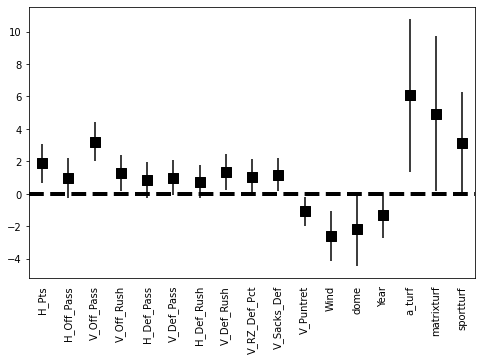

In [426]:
err_series = OLS.params - OLS.conf_int()[0]
coef_df = pd.DataFrame({'coef': OLS.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')

In [421]:
# 
import statsmodels.api as sm
train_ratio = 0.7
X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','H_Def_Pass','V_Def_Pass','H_Def_Rush',
            'V_Def_Rush','V_RZ_Def_Pct','V_Sacks_Def','V_Puntret','Wind','grass','dome','Year']]
y = dfgame['Tot_Pts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
sca_train = pd.DataFrame(robust.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
sca_train = sm.add_constant(sca_train)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
OLS.summary()

MAE = 10.471431856843974
Training Accuracy = 0.5659432387312187


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     7.300
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.80e-16
Time:                        12:20:59   Log-Likelihood:                -4859.0
No. Observations:                1214   AIC:                             9752.
Df Residuals:                    1197   BIC:                             9839.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           44.7404      0.601     74.387      0.000      43.560      45.920
H_Pts            1.3001      0.739      1.760      0.079      -0.149       2.750
H_Off_Pass       1.3688      0.737      1.858      0.063      -0.076       2.814
V_Off_Pass       3.2084      0.611      5.250      0.000       2.009       4.407
H_Off_Rush       0.9974      0.652      1.529      0.127      -0.282       2.277
V_Off_Rush       1.3956      0.567      2.461      0.014       0.283       2.508
H_Def_Pass       0.9291      0.570      1.629      0.103      -0.190       2.048
V_Def_Pass       1.0364      0.559      1.853      0.064      -0.061       2.134
H_Def_Rush       0.9067      0.530      1.711      0.087      -0.133       1.946
V_Def_Rush       1.4053      0.570      2.463      0.014       0.286       2.525
V_RZ_Def_Pct     0.9833      0.554      1.773      0.076      -0.104       2.071
V_Sacks_Def      1.1006      0.514      2.140      0.033       0.092       2.110
V_Puntret       -1.1095      0.456     -2.433      0.015      -2.004      -0.215
Wind            -2.4205      0.779     -3.107      0.002      -3.949      -0.892
grass           -2.2763      0.883     -2.578      0.010      -4.009      -0.544
dome            -2.2594      1.187     -1.903      0.057      -4.589       0.070
Year            -1.1896      0.709     -1.678      0.094      -2.581       0.201
==============================================================================
Omnibus:                        8.233   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.202
Skew:                           0.183   Prob(JB):                       0.0166
Kurtosis:                       3.167   Cond. No.                         4.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

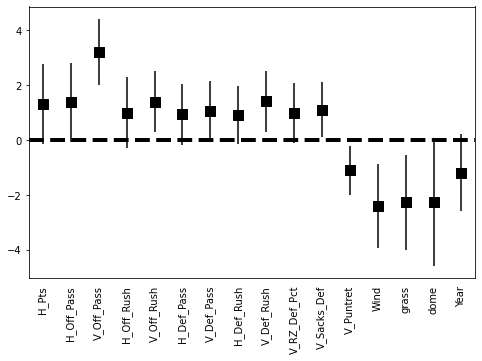

In [423]:
err_series = OLS.params - OLS.conf_int()[0]
coef_df = pd.DataFrame({'coef': OLS.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')

In [427]:
# 
import statsmodels.api as sm
train_ratio = 0.7
X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','H_Def_Pass','V_Def_Pass','H_Def_Rush',
            'V_Def_Rush','V_RZ_Def_Pct','V_Sacks_Def','V_Puntret','Wind','grass','dome','Year','Temperature']]
y = dfgame['Tot_Pts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
sca_train = pd.DataFrame(robust.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
sca_train = sm.add_constant(sca_train)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
OLS.summary()

MAE = 10.465820063740189
Training Accuracy = 0.5651085141903172


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.934
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           3.12e-16
Time:                        12:24:24   Log-Likelihood:                -4858.5
No. Observations:                1214   AIC:                             9753.
Df Residuals:                    1196   BIC:                             9845.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           44.9204      0.626     71.745      0.000      43.692      46.149
H_Pts            1.3619      0.741      1.837      0.066      -0.092       2.816
H_Off_Pass       1.3137      0.739      1.779      0.076      -0.135       2.763
V_Off_Pass       3.1861      0.611      5.210      0.000       1.986       4.386
H_Off_Rush       1.0092      0.652      1.547      0.122      -0.271       2.289
V_Off_Rush       1.3770      0.567      2.427      0.015       0.264       2.490
H_Def_Pass       0.8799      0.572      1.538      0.124      -0.243       2.002
V_Def_Pass       1.0176      0.560      1.819      0.069      -0.080       2.115
H_Def_Rush       0.9503      0.532      1.788      0.074      -0.093       1.993
V_Def_Rush       1.3867      0.571      2.430      0.015       0.267       2.506
V_RZ_Def_Pct     1.0071      0.555      1.815      0.070      -0.082       2.096
V_Sacks_Def      1.0797      0.515      2.098      0.036       0.070       2.090
V_Puntret       -1.1050      0.456     -2.423      0.016      -2.000      -0.210
Wind            -2.3170      0.785     -2.950      0.003      -3.858      -0.776
grass           -2.4675      0.902     -2.735      0.006      -4.238      -0.697
dome            -2.7745      1.288     -2.155      0.031      -5.301      -0.248
Year            -1.1925      0.709     -1.682      0.093      -2.584       0.198
Temperature      0.7396      0.715      1.034      0.301      -0.663       2.143
==============================================================================
Omnibus:                        8.145   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.100
Skew:                           0.184   Prob(JB):                       0.0174
Kurtosis:                       3.159   Cond. No.                         4.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

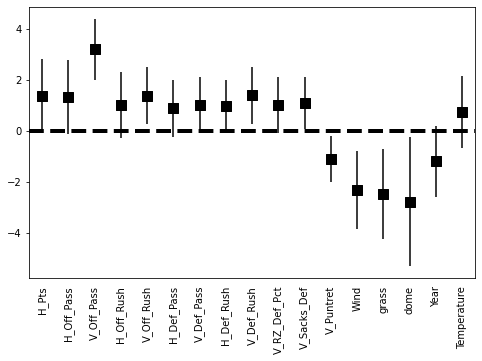

In [428]:
err_series = OLS.params - OLS.conf_int()[0]
coef_df = pd.DataFrame({'coef': OLS.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')

In [52]:
train_ratio = 0.85
path = 'data/df_working5.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.733±0.391, Accuracy = 0.519±0.016
[10.2028101  11.35855609 10.94531507 10.57066376 10.58620051]
                LR Coefficient
a_turf                8.101133
matrixturf            7.360245
sportturf             5.745638
V_Off_Pass            4.417193
fieldturf             3.890611
H_Pts                 3.288340
V_Def_Rush            2.834947
Wind                 -2.583794
dome                 -2.523312
grass                 2.345038
H_Rush_Metric         2.312574
H_Pass_Metric        -2.183779
H_Def_Rush            1.734319
H_Off_Pass            1.628639
V_Def_RZ_Pct          1.547547
Year                 -1.466160
H_TD                 -1.400001
H_Off_Rush           -1.332554
V_Off_Rush            1.325435
V_Pass_Metric        -1.266014
V_Puntret            -1.142696
V_TD                 -1.009501
V_Pts_Opp            -0.907220
V_Sacks_Def           0.877824
V_Poss               -0.828311
V_RZ_Pct              0.820892
H_Plays               0.793014
Week                 

In [51]:
train_ratio = 0.85
path = 'data/df_working5.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X = X.drop(turf,axis=1)
dropped=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp','Year']
X = X.drop(dropped,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.723±0.414, Accuracy = 0.526±0.021
[10.07736203 11.31416506 10.98211995 10.58394396 10.65632885]
                LR Coefficient
V_Off_Pass            3.372361
dome                 -2.510796
Wind                 -2.441556
grass                -2.205197
V_Off_Rush            1.616449
H_Off_Pass            1.610824
H_Off_Rush            1.268890
H_Def_Rush            1.185441
V_Def_RZ_Pct          1.141077
V_Def_Rush            1.114805
V_Puntret            -1.064862
H_Def_Pass            1.035004
V_TO_Gain             0.957151
V_Sacks_Def           0.904377
H_Plays               0.836927
V_Poss               -0.789141
H_TO_Gain             0.787617
V_FG_Pct              0.745540
H_TO_Lost            -0.706670
V_Kickret             0.655105
Week                 -0.602512
H_Sacks_Def           0.594372
H_Def_RZ_Pct         -0.566110
H_TD_on_Def          -0.554619
Temperature           0.515679
V_TD_on_Def          -0.483744
V_Tackles_Loss        0.429127
V_Yds_Pen            

In [417]:
import statsmodels.api as sm
train_ratio = 0.85
X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','H_Def_Pass','V_Def_Pass','H_Def_Rush',
            'V_Def_Rush','V_RZ_Def_Pct','V_Sacks_Def','V_Puntret','Wind','grass','dome','Year']]
y = dfgame['Tot_Pts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
LR = linear_model.LinearRegression()
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.567±0.373, Accuracy = 0.532±0.025
[10.05400968 11.21060217 10.59576219 10.43051014 10.54191235]
              LR Coefficient
V_Off_Pass          3.255272
Wind               -2.449338
dome               -2.179673
grass              -2.151475
Year               -1.412589
H_Off_Pass          1.378958
V_Off_Rush          1.340438
V_Sacks_Def         1.321096
V_Def_Rush          1.259489
V_Puntret          -1.210262
H_Pts               1.167069
H_Off_Rush          1.096150
V_RZ_Def_Pct        0.984158
H_Def_Pass          0.965912
V_Def_Pass          0.909318
H_Def_Rush          0.826367


In [61]:
# Random Forest
from sklearn import ensemble
import graphviz
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
rf_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=200,max_depth=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
importance = rf_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(f'MAE = {mean_absolute_error(y_train,y_pred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,y_pred)}')
print(coef_sort)

MAE = 10.172695628976479
Training Accuracy = 0.5553264604810997
                Importance
V_Off_Pass        0.190548
H_Off_Pass        0.152090
H_Pts             0.097897
V_Def_RZ_Pct      0.045486
V_Def_Pass        0.033397
H_Off_Rush        0.033317
V_Pts             0.024376
Temperature       0.022585
V_TD              0.022398
H_RZ_Pct          0.021918
H_Pass_Metric     0.021226
H_Def_Pass        0.019303
V_TO_Gain         0.016182
V_Def_Rush        0.015826
V_Puntret         0.015745
V_Plays           0.015640
V_Pts_Opp         0.015142
H_Puntret         0.014516
V_RZ_Pct          0.014457
H_Plays           0.012820
V_Off_Rush        0.012598
H_Def_Rush        0.011548
H_TO_Gain         0.010824
V_Poss            0.010802
Wind              0.010430
H_Yds_Pen         0.010013
H_Rush_Metric     0.009929
H_Pts_Opp         0.009908
V_Kickret         0.009857
H_TD              0.009730
H_Def_RZ_Pct      0.009602
H_Kickret         0.007731
H_FG_Pct          0.007167
H_Poss            

In [431]:
# Random Forest
from sklearn import ensemble
import graphviz
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
dropped=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp']
X = X.drop(dropped,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
rf_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=200,max_depth=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
importance = rf_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(f'MAE = {mean_absolute_error(y_train,y_pred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,y_pred)}')
print(coef_sort)

MAE = 10.195757037753097
Training Accuracy = 0.5608247422680412
                Importance
V_Off_Pass        0.212595
H_Off_Pass        0.204289
V_RZ_Def_Pct      0.066857
H_Off_Rush        0.059177
V_Def_Pass        0.039474
Temperature       0.030648
H_Def_Pass        0.029577
H_RZ_Pct          0.024586
V_Plays           0.023144
H_Puntret         0.022278
V_TO_Gain         0.021692
V_Def_Rush        0.018641
V_RZ_Pct          0.018226
V_Off_Rush        0.018043
V_Puntret         0.017543
H_TO_Gain         0.017014
H_Plays           0.016080
V_Poss            0.015843
Wind              0.013782
H_Def_Rush        0.013569
H_RZ_Def_Pct      0.012858
H_Kickret         0.010226
H_Yds_Pen         0.009932
V_Kickret         0.008776
H_Poss            0.008204
V_Yds_Pen         0.007924
V_FG_Pct          0.007693
H_Tackles_Loss    0.007339
V_TO_Lost         0.006938
H_FG_Pct          0.006602
V_Tackles_Loss    0.006414
H_TO_Lost         0.005862
V_Sacks_Def       0.003524
grass             

In [65]:
# Random Forest
from sklearn import ensemble
import graphviz
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X = X.drop(turf,axis=1)
dropped=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp','Year','H_Kickret','H_Yds_Pen','V_Kickret','H_Poss','V_Yds_Pen','V_FG_Pct',
         'H_Tackles_Loss','V_Tackles_Loss','V_TO_Lost','H_FG_Pct','H_TO_Lost','grass','V_Sacks_Def',
         'H_TD_on_Def','Week','H_Sacks_Def','V_TD_on_Def','dome']
X = X.drop(dropped,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
rf_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=200,max_depth=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
importance = rf_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(f'MAE = {mean_absolute_error(y_train,y_pred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,y_pred)}')
print(coef_sort)

MAE = 10.202294757364566
Training Accuracy = 0.5615120274914089
              Importance
V_Off_Pass      0.224700
H_Off_Pass      0.211933
V_Def_RZ_Pct    0.073866
H_Off_Rush      0.067512
V_Def_Pass      0.049835
Temperature     0.037732
H_Def_Pass      0.036031
H_Puntret       0.027394
H_RZ_Pct        0.026886
V_TO_Gain       0.025892
V_Plays         0.022997
H_TO_Gain       0.022915
V_Puntret       0.022851
V_Poss          0.021124
V_Def_Rush      0.020762
V_RZ_Pct        0.020469
H_Plays         0.019177
V_Off_Rush      0.018637
H_Def_RZ_Pct    0.017463
Wind            0.016443
H_Def_Rush      0.015382


In [429]:
# Random Forest
from sklearn import ensemble
import graphviz
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X = X.drop(turf,axis=1)
dropped=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp','Year','H_Kickret','H_Yds_Pen','V_Kickret','H_Poss','V_Yds_Pen','V_FG_Pct',
         'H_Tackles_Loss','V_Tackles_Loss','V_TO_Lost','H_FG_Pct','H_TO_Lost','grass','V_Sacks_Def',
         'H_TD_on_Def','Week','H_Sacks_Def','V_TD_on_Def','dome']
X = X.drop(dropped,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
rf_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=200,max_depth=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
importance = rf_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(f'MAE = {mean_absolute_error(y_train,y_pred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,y_pred)}')
print(coef_sort)

KeyError: "['dessograss'] not found in axis"

In [109]:
from sklearn import ensemble
import graphviz
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
rf_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=200,max_depth=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
importance = rf_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(f'MAE = {mean_absolute_error(y_train,y_pred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,y_pred)}')
print(coef_sort[:60])

MAE = 10.179483330814104
Training Accuracy = 0.554639175257732
                        Importance
V_Off_Pass                0.186429
H_Off_Pass                0.144490
H_Pts                     0.096776
V_Def_RZ_Pct              0.043629
V_Def_Pass                0.031737
H_Off_Rush                0.027712
V_Pts                     0.024341
H_Pass_Metric             0.021905
V_TD                      0.020726
Temperature               0.020500
H_RZ_Pct                  0.019694
H_Def_Pass                0.019172
V_Pts_Opp                 0.014756
V_TO_Gain                 0.013964
V_Puntret                 0.013652
V_Def_Rush                0.013316
V_Plays                   0.012857
V_Off_Rush                0.012482
V_RZ_Pct                  0.012388
H_Puntret                 0.011950
H_Plays                   0.011849
H_Def_Rush                0.011811
V_Poss                    0.011788
H_New Orleans Saints      0.011586
H_TO_Gain                 0.010376
Wind                      0

In [110]:
from sklearn import ensemble
import graphviz
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
y = dfgame['Tot_Pts']
X = X.drop(turf,axis=1)
dropped=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
        'H_Pts_Opp','V_Pts_Opp','Year','H_Kickret','H_Yds_Pen','V_Kickret','H_Poss','V_Yds_Pen','V_FG_Pct',
         'H_Tackles_Loss','V_Tackles_Loss','V_TO_Lost','H_FG_Pct','H_TO_Lost','grass','V_Sacks_Def',
         'H_TD_on_Def','Week','H_Sacks_Def','V_TD_on_Def','dome']
X = X.drop(dropped,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
rf_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=200,max_depth=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
importance = rf_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(f'MAE = {mean_absolute_error(y_train,y_pred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,y_pred)}')
print(coef_sort[:60])

MAE = 10.21305308813198
Training Accuracy = 0.5608247422680412
                        Importance
V_Off_Pass                0.220891
H_Off_Pass                0.200225
V_Def_RZ_Pct              0.068780
H_Off_Rush                0.056069
V_Def_Pass                0.045694
H_Def_Pass                0.033657
Temperature               0.033002
H_RZ_Pct                  0.023703
H_Puntret                 0.022762
V_TO_Gain                 0.022307
H_TO_Gain                 0.021230
H_New Orleans Saints      0.019913
V_Plays                   0.019904
V_Def_Rush                0.019186
V_Puntret                 0.018316
H_Plays                   0.018313
V_RZ_Pct                  0.017400
V_Off_Rush                0.017079
V_Poss                    0.016401
H_Def_RZ_Pct              0.015217
H_Def_Rush                0.014872
Wind                      0.014183
H_Los Angeles Rams        0.008550
V_Philadelphia Eagles     0.008363
V_Kansas City Chiefs      0.007464
V_New York Giants         0

In [ ]:
from sklearn.linear_model import Lasso
# path = 'data/df_working6_sh.pkl'.format(n)
# with open(path, 'rb') as f:
#     df = pickle.load(f)
# X = df.drop(turf,axis=1)
path = 'data/df_working6.pkl'.format(n)
with open(path, 'rb') as f:
    df = pickle.load(f)
X = df.drop(turf,axis=1)
X = X.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = df['Tot_Pts']
lasso = Lasso(alpha=0.01,normalize=True)
lasso.fit(X,y)
lasso_coef = lasso.fit(X,y).coef_
coef=get_coef(lasso_coef,X.columns)
print(coef)

In [14]:
train_ratio = 0.85
mae = np.empty(7)
acc = np.empty(7)
ou = np.empty(7)
acc_ext = np.empty(7)
for n in range(7):
    path = 'data/df_working'+str(n+1)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = dfgame['Tot_Pts']
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX = XX.drop(turf,axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    m, a = regress(LR,XX_train,XX_test,yy_train,yy_test,
                   print_metrics=False,print_coef=False,return_metrics=True)
    ou[n] = mean_absolute_error(yy_test,dfgame.loc[XX_test.index,'Over/Under'])
    mae[n] = m
    acc[n] = a
print(mae)
print(acc)
print(ou-mae)

[11.34933801 11.16744056 10.48705836 10.59635947 11.09379895 10.69871393
 10.22553897]
[0.45892351 0.53012048 0.50645161 0.51590106 0.54509804 0.55339806
 0.51442308]
[-0.83544912 -0.44422627 -0.28513529 -0.24095878 -0.50567634 -0.25767619
 -0.40714275]


In [ ]:
fig = plt.figure()
_ = fig.add_subplot(3,1,1)
_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('RMSE Diff')
_ = plt.ylim(-0.8,0)
#_ = plt.plot(np.arange(1,len(rmse)+1),rmse,color='blue')
#_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse,color='red')
_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse-rmse,color='green')
_ = fig8.add_subplot(3,1,2)
#_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('Accuracy')
_ = plt.ylim(0.49,0.60)
_ = plt.plot(np.arange(1,len(acc)+1),acc,color='blue')
_ = plt.plot(np.arange(1,len(acc)+1),acc_ext,color='red')
_ = fig8.add_subplot(3,1,3)
_ = plt.ylabel('RMSE Diff')
_ = plt.plot(np.arange(1,len(acc)+1),bench_rmse_ext-rmse_ext,color='lightgreen')
_ = plt.ylim(-1.0,-0.0)
fig.show()
#fig8.savefig('plots/fig8.png')

In [ ]:
factor=np.arange(0.0,0.75,0.05)
mae=np.empty(len(factor))
acc=np.empty(len(factor))
for ind,n in enumerate(factor):
    path = 'data/df_working6_{:.2f}.pkl'.format(n)
    with open(path, 'rb') as f:
        df = pickle.load(f)
    df.dropna(inplace=True)

    X = df.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    X = X.drop(turf,axis=1)
    X = X.drop(vifdrop,axis=1)
    y = df['Tot_Pts']
    wtx_train,wtx_test,wty_train,wty_test = train_test_split(X,y,test_size = 1-train_ratio,random_state = 77)
    m, a = regress(LR,wtx_train,wtx_test,wty_train,wty_test,
                   print_metrics=True,print_coef=False,return_metrics=True)
    mae[ind]=m
    acc[ind]=a
print(mae)
print(acc)

In [ ]:
from sklearn.linear_model import Ridge
cols=['V_Def_RZ_Pct','H_Pts','Wind','V_Pts','V_Tackles_Loss','V_Off_Pass','H_Def_Rush','H_Off_Pass',
      'V_Def_Pass','H_Yds_Pen','V_Def_Rush','H_Def_Pass']
path = 'data/df_working6.pkl'.format(n)
with open(path, 'rb') as f:
    df = pickle.load(f)
X = df.drop(turf,axis=1)
X = X[cols]
y = df['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
alphas=np.logspace(-3, 0, 40)
mae = np.empty(40)
acc = np.empty(40)
for ind,alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha,normalize=True)
    m,a=regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=False,return_metrics=True)
    mae[ind] = m
    acc[ind] = a
print(mae)
print(acc)

In [ ]:
ridge=Ridge(alpha=0.15,normalize=True)
regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=True,return_metrics=False)

In [ ]:
from sklearn.linear_model import Ridge
cols=['H_Pts', 'V_Pts', 'H_Off_Pass', 'V_Off_Pass', 'H_Def_Rush','V_Def_Rush', 'H_RZ_Pct', 'V_RZ_Pct', 
      'H_Sacks_Def', 'Wind', 'grass','dome']
path = 'data/df_working6.pkl'
with open(path, 'rb') as f:
    df = pickle.load(f)
X = df.drop(turf,axis=1)
X = X[cols]
y = df['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
alphas=np.logspace(-3, 0, 40)
mae = np.empty(40)
acc = np.empty(40)
for ind,alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha,normalize=True)
    m,a=regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=False,return_metrics=True)
    mae[ind] = m
    acc[ind] = a
print(mae)
print(acc)

In [ ]:
ridge=Ridge(alpha=0.08,normalize=True)
regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=True,return_metrics=False)

In [164]:
import statsmodels.api as sm
train_ratio = 0.7
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf','dessograss']
X = dfnew.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(turf,axis=1)
y = dfnew['Tot_Pts']
X = X.drop(['Year'],axis=1)
X = X.drop(['H_TD','V_TD'],axis=1)
X = X.drop(['H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric'],axis=1)
#vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_Pts','V_Pts',
#        'H_Pts_Opp','V_Pts_Opp','Year']
#X = X.drop(vifdrop,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
sca_train = pd.DataFrame(robust.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
sca_train = sm.add_constant(sca_train)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
#get_coef(LR.coef_,X_train.columns)
OLS.summary()

MAE = 10.621821497817693
Training Accuracy = 0.5461830451286377


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.177
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           1.05e-31
Time:                        20:05:10   Log-Likelihood:                -9701.4
No. Observations:                2416   AIC:                         1.949e+04
Df Residuals:                    2372   BIC:                         1.975e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             43.3279      0.464     93.316      0.000      42.417      44.238
H_Pts              1.1925      0.867      1.376      0.169      -0.507       2.892
H_Pts_Opp          0.5987      0.795      0.753      0.452      -0.961       2.159
V_Pts              0.3103      0.898      0.346      0.730      -1.450       2.071
V_Pts_Opp         -0.7589      0.810     -0.937      0.349      -2.348       0.830
H_Off_Pass         1.7415      0.798      2.182      0.029       0.177       3.306
V_Off_Pass         3.5774      0.816      4.383      0.000       1.977       5.178
H_Off_Rush         0.9197      0.571      1.612      0.107      -0.199       2.039
V_Off_Rush         1.4659      0.583      2.513      0.012       0.322       2.610
H_Def_Pass         0.5946      0.594      1.000      0.317      -0.571       1.760
V_Def_Pass         1.1832      0.575      2.058      0.040       0.056       2.311
H_Def_Rush         0.6251      0.567      1.103      0.270      -0.487       1.737
V_Def_Rush         0.9762      0.559      1.747      0.081      -0.120       2.072
H_TD_on_Def       -0.4590      0.363     -1.265      0.206      -1.171       0.253
V_TD_on_Def       -0.2899      0.368     -0.787      0.431      -1.012       0.432
H_FG_Pct           0.0644      0.351      0.183      0.855      -0.624       0.753
V_FG_Pct           0.9267      0.396      2.342      0.019       0.151       1.702
H_RZ_Pct          -0.0068      0.547     -0.012      0.990      -1.080       1.066
V_RZ_Pct          -0.1689      0.542     -0.312      0.755      -1.232       0.894
H_RZ_Def_Pct      -0.3240      0.477     -0.679      0.497      -1.260       0.612
V_RZ_Def_Pct       0.7806      0.469      1.663      0.096      -0.140       1.701
H_Poss             0.0251      0.679      0.037      0.971      -1.307       1.357
V_Poss            -0.5198      0.628     -0.827      0.408      -1.752       0.713
H_Plays            0.2971      0.592      0.502      0.616      -0.863       1.457
V_Plays           -0.5735      0.571     -1.005      0.315      -1.693       0.546
H_TO_Gain          0.1003      0.466      0.215      0.830      -0.814       1.015
V_TO_Gain          0.3216      0.467      0.688      0.491      -0.594       1.238
H_TO_Lost         -0.0662      0.472     -0.140      0.888      -0.991       0.859
V_TO_Lost          0.2657      0.461      0.577      0.564      -0.638       1.169
H_Yds_Pen          0.6383      0.393      1.625      0.104      -0.132       1.408
V_Yds_Pen         -0.2251      0.387     -0.581      0.561      -0.984       0.534
H_Sacks_Def        0.4087      0.444      0.921      0.357      -0.462       1.279
V_Sacks_Def        0.5400      0.438      1.232      0.218      -0.320       1.400
H_Tackles_Loss     0.3970      0.479      0.829      0.407      -0.542       1.336
V_Tackles_Lo

In [175]:
import statsmodels.api as sm
train_ratio = 0.7
X = dfnew[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','V_Def_Pass','V_Def_Rush','V_FG_Pct',
          'V_Puntret','Wind','H_Yds_Pen','V_Kickret','grass']]
y = dfnew['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
sca_train = pd.DataFrame(robust.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
sca_train = sm.add_constant(sca_train)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
OLS.summary()

MAE = 10.681881134063518
Training Accuracy = 0.5415436524673134


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     18.63
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           4.78e-42
Time:                        20:31:31   Log-Likelihood:                -9713.6
No. Observations:                2416   AIC:                         1.946e+04
Df Residuals:                    2402   BIC:                         1.954e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.6934      0.388    112.515      0.000      42.932      44.455
H_Pts          0.9816      0.519      1.892      0.059      -0.036       1.999
H_Off_Pass     2.1351      0.538      3.972      0.000       1.081       3.189
V_Off_Pass     3.3120      0.420      7.879      0.000       2.488       4.136
H_Off_Rush     0.9150      0.456      2.007      0.045       0.021       1.809
V_Off_Rush     1.2485      0.398      3.134      0.002       0.467       2.030
V_Def_Pass     1.2625      0.390      3.236      0.001       0.497       2.028
V_Def_Rush     0.9685      0.391      2.474      0.013       0.201       1.736
V_FG_Pct       0.9820      0.367      2.676      0.007       0.262       1.702
V_Puntret     -0.7301      0.322     -2.269      0.023      -1.361      -0.099
Wind          -2.1905      0.484     -4.527      0.000      -3.139      -1.242
H_Yds_Pen      0.7895      0.372      2.119      0.034       0.059       1.520
V_Kickret      0.5796      0.306      1.893      0.058      -0.021       1.180
grass         -0.7317      0.588     -1.245      0.213      -1.885       0.421
==============================================================================
Omnibus:                       46.875   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.774
Skew:                           0.326   Prob(JB):                     1.56e-11
Kurtosis:                       3.261   Cond. No.                         3.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
import statsmodels.api as sm
train_ratio = 0.7
X = dfgame[['H_Pts','H_Off_Pass','V_Off_Pass','H_Off_Rush','V_Off_Rush','V_Def_Pass','V_Def_Rush','V_FG_Pct',
          'V_Puntret','Wind','H_Yds_Pen','V_Kickret','grass']]
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
sca_train = pd.DataFrame(robust.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
sca_train = sm.add_constant(sca_train)
OLS = sm.OLS(y_train, sca_train).fit()
ypred=OLS.predict(sca_train)
print(f'MAE = {mean_absolute_error(y_train,ypred)}')
print(f'Training Accuracy = {ou_accuracy(y_train,ypred)}')
OLS.summary()

MAE = 10.578375444017226
Training Accuracy = 0.5333889816360601


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.891
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           2.74e-15
Time:                        20:33:14   Log-Likelihood:                -4865.7
No. Observations:                1214   AIC:                             9759.
Df Residuals:                    1200   BIC:                             9831.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3668      0.557     79.717      0.000      43.275      45.459
H_Pts          1.5017      0.723      2.076      0.038       0.082       2.921
H_Off_Pass     1.1588      0.744      1.557      0.120      -0.302       2.619
V_Off_Pass     3.6465      0.602      6.053      0.000       2.465       4.828
H_Off_Rush     0.5612      0.641      0.875      0.382      -0.697       1.819
V_Off_Rush     1.7413      0.558      3.122      0.002       0.647       2.835
V_Def_Pass     0.9655      0.549      1.759      0.079      -0.111       2.042
V_Def_Rush     1.3221      0.549      2.407      0.016       0.244       2.400
V_FG_Pct       0.7506      0.510      1.473      0.141      -0.249       1.750
V_Puntret     -0.9476      0.447     -2.119      0.034      -1.825      -0.070
Wind          -1.4987      0.649     -2.308      0.021      -2.773      -0.225
H_Yds_Pen      0.2793      0.530      0.527      0.598      -0.761       1.320
V_Kickret      0.5300      0.475      1.115      0.265      -0.403       1.463
grass         -1.7466      0.818     -2.135      0.033      -3.352      -0.142
==============================================================================
Omnibus:                        9.991   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.968
Skew:                           0.214   Prob(JB):                      0.00685
Kurtosis:                       3.120   Cond. No.                         3.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""